In [1]:
import sys
sys.path.append("../../Chapter_3/")

import torch
from Bio import SeqIO
import yaml

import pandas as pd
import pickle

from Utils.train import BlockInputShapeReformatter

import seaborn as sbn
import yaml

In [2]:
unrefined_model = torch.load("../Models/NonRefinedMainModel.torch")
refined_model = torch.load("../Models/TatRefinedMainModel.torch")

unrefined_model.eval()
refined_model.eval();

In [3]:
with open("../Data/EncodedData/EncodedCARESPositivemiRNACombos.pickle",'rb') as datafile:
    positive_cares_mirna_combos = pickle.load(datafile)
    
with open("../Data/EncodedData/CARESPositivemiRNAComboIDs.pickle",'rb') as datafile:
    positive_combo_labels = pickle.load(datafile)
    
with open("../Data/EncodedData/EncodedCARESNegativemiRNACombos.pickle",'rb') as datafile:
    negative_cares_mirna_combos = pickle.load(datafile)
    
with open("../Data/EncodedData/CARESNegativemiRNAComboIDs.pickle",'rb') as datafile:
    negative_combo_labels = pickle.load(datafile)

In [4]:
shape_reformatter = BlockInputShapeReformatter()
BLOCKNAME = "StackedRes"

cares_interacting_mirna_combos = [shape_reformatter.reformat_input(BLOCKNAME, positive_cares_mirna_combos[i]) for i in range(2)]
cares_non_interacting_mirna_combos = [shape_reformatter.reformat_input(BLOCKNAME, negative_cares_mirna_combos[i]) for i in range(2)]

In [5]:
# Data is saved as (protein,RNA) order, but needs to be input as (RNA,protein) order
unrefined_interacting_combo_predictions = unrefined_model(cares_interacting_mirna_combos[-1].cuda(), cares_interacting_mirna_combos[0].cuda()).detach().cpu().numpy().flatten()
unrefined_noninteracting_combo_predictions = unrefined_model(cares_non_interacting_mirna_combos[-1].cuda(), cares_non_interacting_mirna_combos[0].cuda()).detach().cpu().numpy().flatten()

refined_interacting_combo_predictions = refined_model(cares_interacting_mirna_combos[-1].cuda(), cares_interacting_mirna_combos[0].cuda()).detach().cpu().numpy().flatten()
refined_noninteracting_combo_predictions = refined_model(cares_non_interacting_mirna_combos[-1].cuda(), cares_non_interacting_mirna_combos[0].cuda()).detach().cpu().numpy().flatten()

In [6]:
def generate_combo_df(combo_predictions, combo_labels):
    cares_ids, mirna_ids = zip(*combo_labels)

    df = pd.DataFrame([cares_ids, mirna_ids, combo_predictions], index = ['CARES_id','miRNA_name','prediction']).T
    df = df.pivot(index = 'CARES_id', columns = 'miRNA_name', values = 'prediction')
    df = df.astype(float)
    return df

In [7]:
unrefined_interact_df = generate_combo_df(unrefined_interacting_combo_predictions, positive_combo_labels)
unrefined_noninteract_df = generate_combo_df(unrefined_noninteracting_combo_predictions, negative_combo_labels)

refined_interact_df = generate_combo_df(refined_interacting_combo_predictions, positive_combo_labels)
refined_noninteract_df = generate_combo_df(refined_noninteracting_combo_predictions, negative_combo_labels)

In [8]:
import re

def isolate_patient_id_number(complete_id : str) -> int:
    return int(re.sub('A0+(\d+)-.*',r'\1', complete_id))

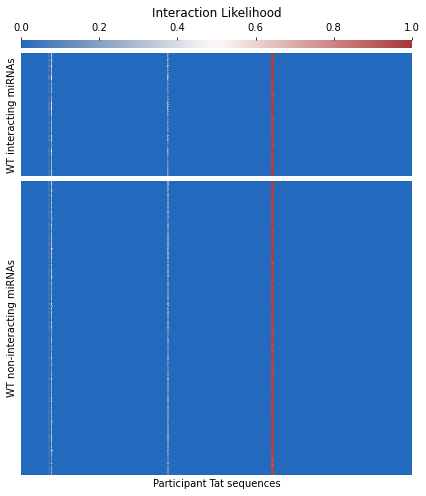

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (7,8))
gs = fig.add_gridspec(3,2, height_ratios = [0.02, 0.29, 0.69], wspace = 0.05, hspace = 0.03)

cbar = fig.add_subplot(gs[0,:])
interact_heatmap = fig.add_subplot(gs[1,:])
noninteract_heatmap = fig.add_subplot(gs[2,:])

g = sbn.heatmap(unrefined_interact_df.T,
                cmap = 'vlag', xticklabels=False, yticklabels=False,
                vmin = 0, vmax = 1,
                cbar_kws = {'orientation': 'horizontal'},
                cbar_ax = cbar,
                ax = interact_heatmap)

g = sbn.heatmap(unrefined_noninteract_df.T,
                cmap = 'vlag', xticklabels=False, yticklabels=False,
                vmin = 0, vmax = 1,
                cbar = False,
                ax = noninteract_heatmap)

cbar.xaxis.tick_top()
cbar.set_title("Interaction Likelihood")

interact_heatmap.set_ylabel("WT interacting miRNAs")
interact_heatmap.set_xlabel("")

noninteract_heatmap.set_ylabel("WT non-interacting miRNAs")

#plt.tight_layout()
noninteract_heatmap.set_xlabel("Participant Tat sequences")

plt.savefig("UnrefinedCARESInteractionPrediction.png", bbox_inches = 'tight', dpi = 300)

In [25]:
all_unrefined_results = pd.concat([unrefined_interact_df, unrefined_noninteract_df], axis = 1).T
all_unrefined_results

CARES_id,A0001-R01,A0001-R03,A0001-R09,A0002-R02,A0002-R11,A0002-R14,A0003-R00,A0004-R10,A0005-R00,A0005-R01,...,B0076-R00,B0146-R00,B0147-R00,B0303-R02,B0325-R00,B0325-R01,B0485-R00,B0522-R00,B0522-R01,B0538-R01
miRNA_name,,,,,,,,,,,,,,,,,,,,,
hsa-let-7g,2.530119e-07,1.133406e-06,0.000002,0.000014,0.000033,0.000006,0.000004,0.000040,0.000029,0.000126,...,0.000182,0.000939,0.000014,0.000030,0.000008,0.000013,0.000006,0.000041,0.000025,0.000025
hsa-let-7i,2.974811e-07,1.332612e-06,0.000003,0.000017,0.000038,0.000007,0.000005,0.000047,0.000034,0.000148,...,0.000214,0.001104,0.000017,0.000036,0.000010,0.000015,0.000007,0.000048,0.000030,0.000029
hsa-miR-106,1.620080e-07,7.257374e-07,0.000002,0.000009,0.000021,0.000004,0.000003,0.000026,0.000019,0.000080,...,0.000116,0.000601,0.000009,0.000019,0.000005,0.000008,0.000004,0.000026,0.000016,0.000016
hsa-miR-125a-3p,3.769550e-07,1.688628e-06,0.000004,0.000021,0.000049,0.000008,0.000007,0.000060,0.000044,0.000187,...,0.000271,0.001398,0.000021,0.000045,0.000012,0.000019,0.000009,0.000061,0.000038,0.000037
hsa-miR-128,1.972798e-07,8.837441e-07,0.000002,0.000011,0.000025,0.000004,0.000003,0.000031,0.000023,0.000098,...,0.000142,0.000732,0.000011,0.000024,0.000006,0.000010,0.000005,0.000032,0.000020,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-9,2.313806e-07,1.036504e-06,0.000002,0.000013,0.000030,0.000005,0.000004,0.000037,0.000027,0.000115,...,0.000166,0.000859,0.000013,0.000028,0.000007,0.000012,0.000006,0.000037,0.000023,0.000023
hsa-miR-95,1.125158e-07,5.040314e-07,0.000001,0.000006,0.000014,0.000003,0.000002,0.000018,0.000013,0.000056,...,0.000081,0.000418,0.000006,0.000014,0.000004,0.000006,0.000003,0.000018,0.000011,0.000011
hsa-miR-96,1.393418e-07,6.241992e-07,0.000001,0.000008,0.000018,0.000003,0.000002,0.000022,0.000016,0.000069,...,0.000100,0.000517,0.000008,0.000017,0.000005,0.000007,0.000004,0.000022,0.000014,0.000014


In [99]:
all_unrefined_described = all_unrefined_results.describe()

unrefined_exclusive_binders = all_unrefined_described.loc['mean',:] > 0.9
# (all_unrefined_results.describe().loc['max',:] - all_unrefined_results.describe().loc['min',:]) > 0.05
unrefined_variable_binders = all_unrefined_described.loc['std',:] > 0.01

unrefined_exclusive_binders = all_unrefined_described.loc['mean',:] >= 0.99
unrefined_exclusive_non_binders = all_unrefined_described.loc['mean',:] <= 0.01
print(f"""Number of excluive binders (mean > 0.99) : {sum(unrefined_exclusive_binders)}
Number of exclusive non-binders (mean < 0.01) : {sum(unrefined_exclusive_non_binders)}
Summed total: {sum(unrefined_exclusive_binders) + sum(unrefined_exclusive_non_binders)} / {all_unrefined_described.shape[1]}""")

unrefined_highly_variable_interaction_means = all_unrefined_described.loc['mean',unrefined_variable_binders]
unrefined_highly_variable_interaction_stds = all_unrefined_described.loc['std',unrefined_variable_binders]

print(f"""---
Total highly variable interactions (STD ≥ 0.01): {sum(unrefined_variable_binders)}
Mean and STD of variable interaction means: {round(unrefined_highly_variable_interaction_means.mean(),3)} ± {round(unrefined_highly_variable_interaction_means.std(),3)}
Mean and STD of variable interaction STDs: {round(unrefined_highly_variable_interaction_stds.mean(),3)} ± {round(unrefined_highly_variable_interaction_stds.std(),3)}
---""")


#all_unrefined_described.loc[:,unrefined_variable_binders].round(3)

Number of excluive binders (mean > 0.99) : 0
Number of exclusive non-binders (mean < 0.01) : 291
Summed total: 291 / 296
---
Total highly variable interactions (STD ≥ 0.01): 5
Mean and STD of variable interaction means: 0.478 ± 0.455
Mean and STD of variable interaction STDs: 0.035 ± 0.03
---


In [102]:
all_refined_results = pd.concat([refined_interact_df, refined_noninteract_df], axis = 1).T

all_refined_described = all_refined_results.describe()

refined_exclusive_binders = all_refined_results.describe().loc['mean',:] >= 0.99
refined_exclusive_non_binders = all_refined_results.describe().loc['mean',:] <= 0.01

print(f"""Number of excluive binders (mean > 0.99): {sum(refined_exclusive_binders)} / {all_refined_results.shape[1]} ({round(sum(refined_exclusive_binders) / all_refined_results.shape[1],4)*100}%)
Number of exclusive non-binders (mean < 0.01): {sum(refined_exclusive_non_binders)} / {all_refined_results.shape[1]} ({round(sum(refined_exclusive_non_binders) / all_refined_results.shape[1],4)*100}%)
Summed total: {sum(refined_exclusive_binders) + sum(refined_exclusive_non_binders)} / {all_refined_described.shape[1]} ({round((sum(refined_exclusive_binders) + sum(refined_exclusive_non_binders)) / all_refined_results.shape[1],4)*100}%)
---""")

refined_variable_binders = all_refined_results.describe().loc['std',:] > 0.01

refined_highly_variable_interaction_means = all_refined_described.loc['mean',refined_variable_binders]
refined_highly_variable_interaction_stds = all_refined_described.loc['std',refined_variable_binders]

print(f"""Total highly variable interactions (STD ≥ 0.01): {sum(refined_variable_binders)}
Mean and STD of variable interaction means: {round(refined_highly_variable_interaction_means.mean(),3)} ± {round(refined_highly_variable_interaction_means.std(),3)}
Mean and STD of variable interaction STDs: {round(refined_highly_variable_interaction_stds.mean(),3)} ± {round(refined_highly_variable_interaction_stds.std(),3)}
---""")

#all_refined_described.loc[:,refined_variable_binders].round(3)

Number of excluive binders (mean > 0.99): 51 / 296 (17.23%)
Number of exclusive non-binders (mean < 0.01): 232 / 296 (78.38000000000001%)
Summed total: 283 / 296 (95.61%)
---
Total highly variable interactions (STD ≥ 0.01): 14
Mean and STD of variable interaction means: 0.469 ± 0.292
Mean and STD of variable interaction STDs: 0.156 ± 0.073
---


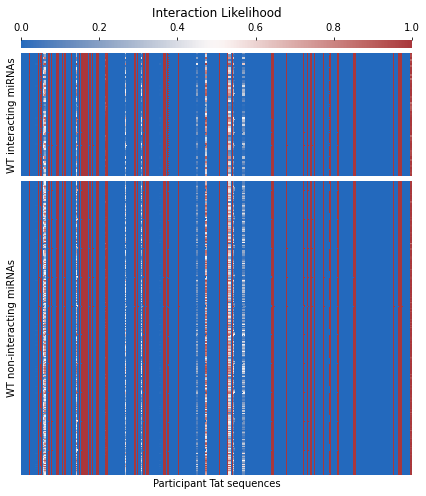

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (7,8))
gs = fig.add_gridspec(3,2, height_ratios = [0.02, 0.29, 0.69], wspace = 0.05, hspace = 0.03)

cbar = fig.add_subplot(gs[0,:])
interact_heatmap = fig.add_subplot(gs[1,:])
noninteract_heatmap = fig.add_subplot(gs[2,:])

g = sbn.heatmap(refined_interact_df.T,
                cmap = 'vlag', xticklabels=False, yticklabels=False,
                vmin = 0, vmax = 1,
                cbar_kws = {'orientation': 'horizontal'},
                cbar_ax = cbar,
                ax = interact_heatmap)

g = sbn.heatmap(refined_noninteract_df.T,
                cmap = 'vlag', xticklabels=False, yticklabels=False,
                vmin = 0, vmax = 1,
                cbar = False,
                ax = noninteract_heatmap)

cbar.xaxis.tick_top()
cbar.set_title("Interaction Likelihood")

interact_heatmap.set_ylabel("WT interacting miRNAs")
interact_heatmap.set_xlabel("")

noninteract_heatmap.set_ylabel("WT non-interacting miRNAs")

#plt.tight_layout()
noninteract_heatmap.set_xlabel("Participant Tat sequences")

plt.savefig("RefinedCARESInteractionPrediction.png", bbox_inches = 'tight', dpi = 300)

In [12]:
refined_interact_df.iloc[:,0].round().to_dict()

{'A0001-R01': 0.0,
 'A0001-R03': 0.0,
 'A0001-R09': 0.0,
 'A0002-R02': 0.0,
 'A0002-R11': 0.0,
 'A0002-R14': 0.0,
 'A0003-R00': 1.0,
 'A0004-R10': 0.0,
 'A0005-R00': 0.0,
 'A0005-R01': 0.0,
 'A0005-R04': 0.0,
 'A0005-R05': 0.0,
 'A0005-R07': 0.0,
 'A0008-R00': 1.0,
 'A0008-R01': 0.0,
 'A0008-R07': 1.0,
 'A0008-R10': 0.0,
 'A0010-R00': 0.0,
 'A0010-R08': 1.0,
 'A0010-R09': 0.0,
 'A0013-R00': 0.0,
 'A0013-R01': 1.0,
 'A0013-R05': 0.0,
 'A0013-R06': 1.0,
 'A0013-R10': 0.0,
 'A0013-R11': 0.0,
 'A0014-R00': 0.0,
 'A0015-R03': 1.0,
 'A0015-R06': 1.0,
 'A0015-R08': 0.0,
 'A0015-R10': 0.0,
 'A0015-R11': 1.0,
 'A0015-R13': 0.0,
 'A0016-R00': 1.0,
 'A0017-R00': 0.0,
 'A0017-R02': 0.0,
 'A0017-R03': 0.0,
 'A0017-R04': 0.0,
 'A0017-R05': 1.0,
 'A0017-R06': 0.0,
 'A0017-R07': 0.0,
 'A0017-R11': 0.0,
 'A0019-R01': 1.0,
 'A0019-R02': 0.0,
 'A0019-R03': 1.0,
 'A0019-R04': 0.0,
 'A0019-R05': 1.0,
 'A0019-R08': 1.0,
 'A0019-R09': 1.0,
 'A0019-R11': 1.0,
 'A0019-R12': 1.0,
 'A0022-R00': 0.0,
 'A0022-R01'

In [13]:
# Because all Tats either interact with or do not interact with a model
patient_maintains_interaction = { patient : {"Maintains interaction" : interact == 1, "Maintains non-interaction" : interact == 0} for patient, interact in refined_interact_df.iloc[:,0].round().to_dict().items()}

In [14]:
with open("../Data/CARESInteractionResults/Patient_maintains_WT_interaction.yml",'w') as outfile:
    yaml.dump(patient_maintains_interaction, outfile)